In [1]:
library(caret)
library(pROC)
library(Kendall)
library(car)
library(bestglm)
library(tidyverse)
library(dummies)
library(ggcorrplot)

Warning message:
"package 'caret' was built under R version 3.6.2"Loading required package: lattice
Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'pROC' was built under R version 3.6.2"Type 'citation("pROC")' for a citation.

Attaching package: 'pROC'

The following objects are masked from 'package:stats':

    cov, smooth, var

Warning message:
"package 'Kendall' was built under R version 3.6.3"Warning message:
"package 'car' was built under R version 3.6.3"Loading required package: carData
Warning message:
"package 'bestglm' was built under R version 3.6.3"Loading required package: leaps
Warning message:
"package 'leaps' was built under R version 3.6.3"Warning message:
"package 'tidyverse' was built under R version 3.6.3"-- Attaching packages --------------------------------------- tidyverse 1.3.0 --
v tibble  2.1.3     v dplyr   0.8.4
v tidyr   1.0.2     v stringr 1.4.0
v readr   1.3.1     v forcats 0.

# Introduction
L'objectif dans ce document est de trouver le meilleur modèle pour expliquer la souscription ou pas d'un client à une dépôt à terme à partir de plusieurs variables récoltées par  l’UC Irvine Machine Learning Repository. Les modèles testés seront uniquement de la **régression logistique**.

Pour la clareté du document, certaines portions de codes ne sont pas intégré au document final.

### Stratégie.
La stratégie est de trouver les meilleurs modèles en utilisant 5 métriques pour faciliter la prise de décision en cas d'égalité. Il s'agit de l'**Accuracy**, l'**AUC**, le **tau de Kendall**, l'**AIC** et le **BIC**.  
Pour que la comparaison ait un sens, et dans un souci de reproductibilité, nous fixerons deux échantillons, d'entraînement et de test, choisis aléatoirement. Pour se faire la fonction `split_test( )` séparera toujours les mêmes individus peu importe les transformation des données que nous effectuerons.

### Condition de validité de la régression logistique 
Dans nos données nous avons 1000 individus et 14 colonnes, dont la variable explicative $Y$ à 2 modalités.  
Dans les données brutes, la modalité $Y = 1$ se compte au nombre de 110. On compte dans notre matrice de design, $X$, 35 variables explicatives (avec les modalités des variables qualitatives).

Or, pour généraliser, la condition de validité de la régression logistique requiert "au moins 5 à 10 évènements par variables explicatives".  
Donc au moins 175 évènements pour $Y = 1$ qui n'en compte que 110 au maximum. Il est impératif donc de réduire nos variables explicatives pour en avoir tout au plus 22 (dans l'hypothèse où nous utilisons l'ensemble des données), et au mieux 10.  
Un des algorithmes que nous testerons (`bestglm( )`) requiert cette réduction de dimension.

In [2]:
split_set <- function(data, trainSize = 0.8){
    #' Divise nos données en partitions train et test
    
    set.seed(2020)
    part <- createDataPartition(data$y, p = trainSize)
    train_set <- data %>% slice(part$Resample1)
    test_set <- data %>% slice(-part$Resample1)
    
    return(list(train_set, test_set))
}

In [3]:
data <- read.delim("bankCC.txt", sep = " ") %>% as_tibble()

# I. Statistique descriptive

Un rapide résumé de nos données.  
Ces statistiques seront utiles pour la sélection des variables.

Visualisons la distribution de nos variables.

In [4]:
summary(data)

      age                 job          marital                  education  
 Min.   :17.00   admin.     :233   divorced:110   basic.4y           : 94  
 1st Qu.:32.00   blue-collar:231   married :599   basic.6y           : 62  
 Median :38.00   technician :168   single  :289   basic.9y           :146  
 Mean   :39.87   services   :110   unknown :  2   high.school        :248  
 3rd Qu.:47.00   management : 82                  professional.course:125  
 Max.   :91.00   retired    : 46                  university.degree  :276  
                 (Other)    :130                  unknown            : 49  
    default       housing         contact    day_of_week    duration     
 no     :786   no     :465   cellular :646   fri:203     Min.   :   6.0  
 unknown:214   unknown: 17   telephone:354   mon:209     1st Qu.: 100.0  
               yes    :518                   thu:216     Median : 174.0  
                                             tue:180     Mean   : 252.0  
                      

In [5]:
library(ggpubr)

p_job_edu <- data %>% 
mutate(job = factor(job, 
                    levels = c(
                        'management', 'admin.', 'self-employed', 'entrepreneur',
                        'technician', 'services', 'housemaid', 'retired',
                        'student', 'unemployed', 'blue-collar', 'unknown'
                    ))) %>% 
filter(job != "unknown") %>% filter(education != "unknown") %>% 
ggplot() + aes(x = job, fill = education) + geom_bar(position="fill") +
coord_flip() + labs(title = "Relation travail - éducation", y = "prop") +
theme(plot.title = element_text(hjust = 0.5))

p_edu <- data %>% 
ggplot() + aes(x = education, fill = y) + geom_bar(position = "fill", alpha = 0.6) +
coord_flip() + labs(title = "Souscription en fonction de l'éducation", y = "prop") +
theme(plot.title = element_text(hjust = 0.5))

edulist <- list(p_job_edu, p_edu)

Warning message:
"package 'ggpubr' was built under R version 3.6.3"Loading required package: magrittr

Attaching package: 'magrittr'

The following object is masked from 'package:purrr':

    set_names

The following object is masked from 'package:tidyr':

    extract



## 1. Variables qualitatives

En analysans la souscription en fonction de l'emploi et du statut marital, on remarque une tendance chez la population célibataire. Il faut pondérer avec le deséquilibre de la variables $Y$ comme décrit précédemment.

L'emploi et le statut marital semblent être des variables discriminantes dans notre problème.

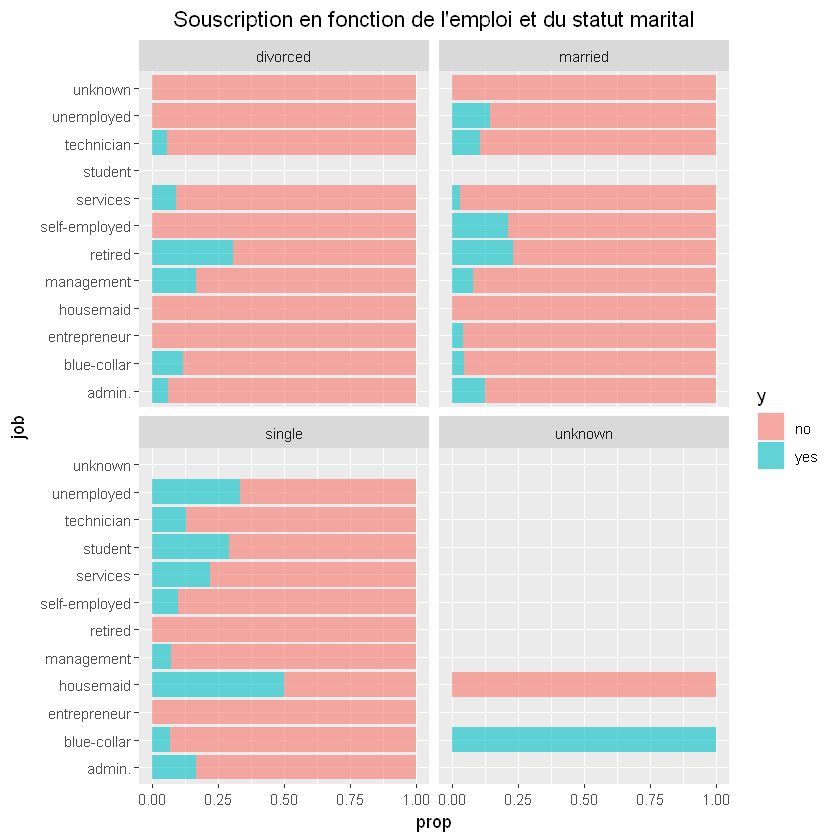

In [6]:
data %>%
ggplot() + aes(x = job, fill = y) + geom_bar(position="fill", alpha = 0.6) + 
coord_flip() + facet_wrap(.~marital) +
labs(title = "Souscription en fonction de l'emploi et du statut marital", y = "prop") +
theme(plot.title = element_text(hjust = 0.5))

Si l'emploi semble avoir un effet sur $Y$, il est naturel d'analyser l'éducation qui semble être corrélée avec.  
Toutefois, celle-ci ne fait varier $Y$ que très peu entre chaque modalité. La variable éducation sera donc moins importante.

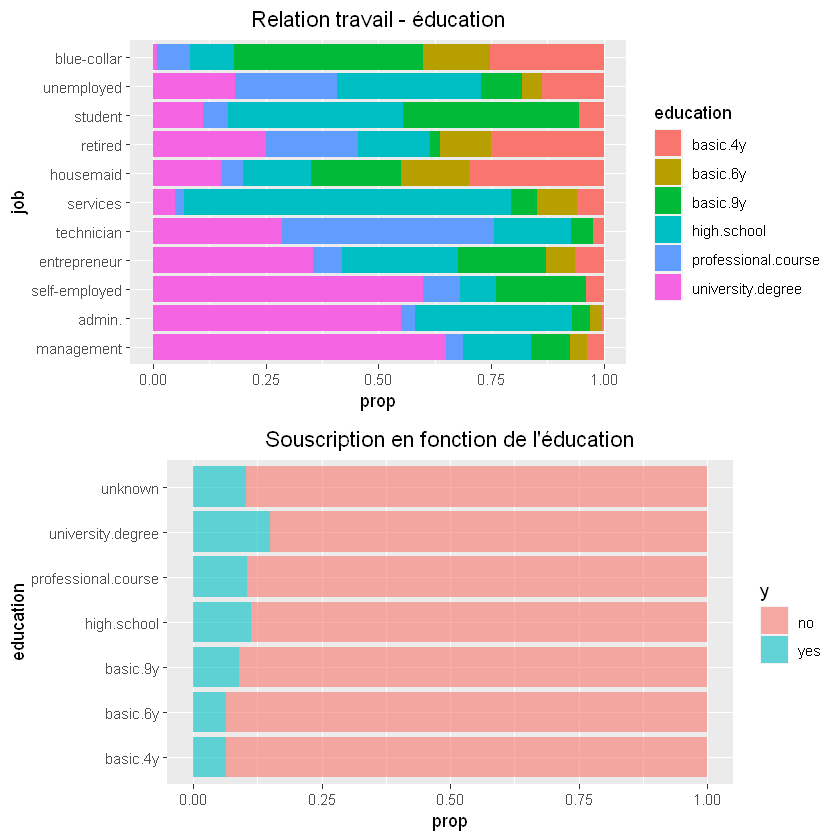

In [7]:
ggarrange(
    plotlist = edulist,
    ncol = 1, nrow = 2
)

Les résultats de la précédente campagne varie significativement entre chaque modalité. On note par exemple que 75% des clients renouvellent leur contrat.  
La variable poutcome sera donc importante.

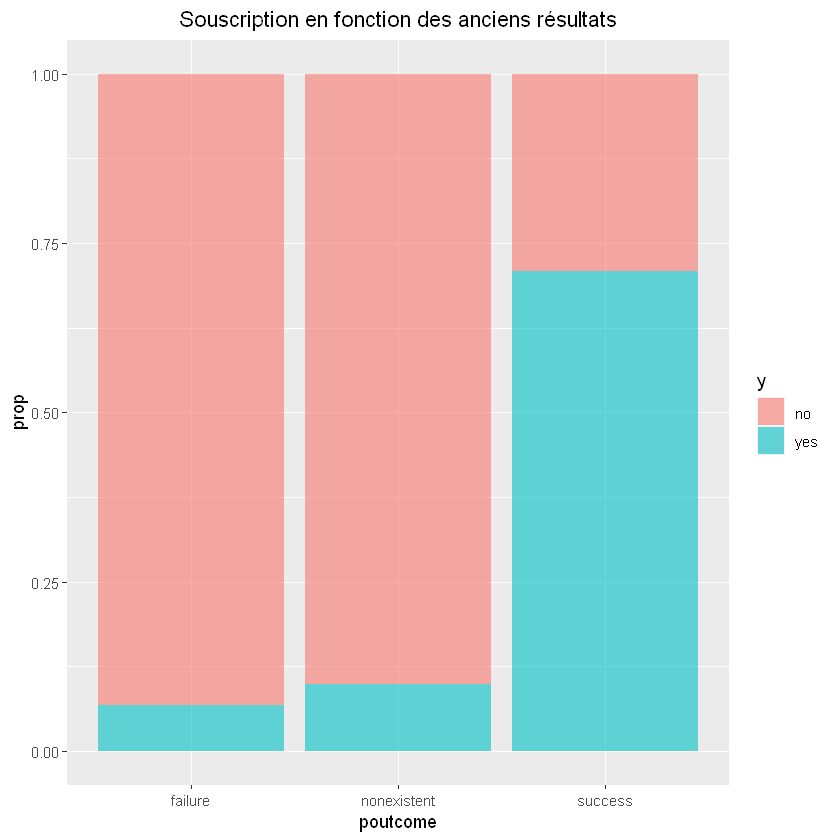

In [8]:
data %>% 
ggplot() + aes(x = poutcome, fill = y) + geom_bar(position = "fill", alpha = 0.6) +
labs(title = "Souscription en fonction des anciens résultats", y = "prop") +
theme(plot.title = element_text(hjust = 0.5))

En mettant dans l'ordre les jours, on peut voir dégager une tendance au long d'une semaine.  
Toutefois, les variances inter-journalière semblent extrêmement basses. On ne retiendra donc pas cette variable.

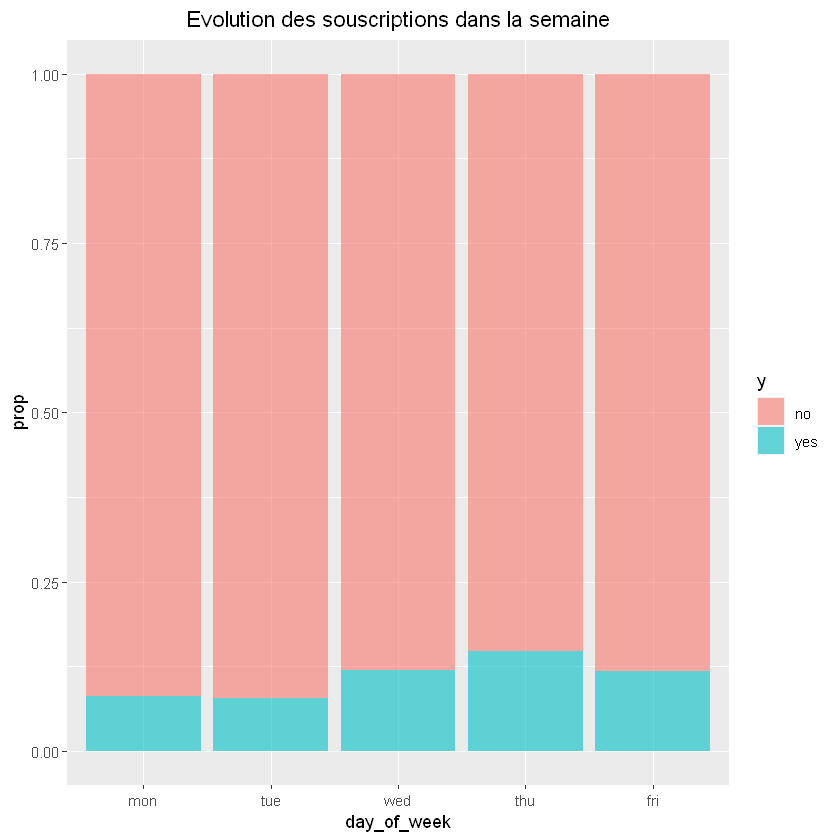

In [9]:
data %>%
mutate(day_of_week = factor(day_of_week,
                            levels = c("mon", "tue", "wed", "thu", "fri"))) %>% 
ggplot() + aes(x = day_of_week, fill = y) + geom_bar(position = "fill", alpha = 0.6) +
labs(title = "Evolution des souscriptions dans la semaine", y = "prop") +
theme(plot.title = element_text(hjust = 0.5))

Entre les deux modalités de la variable contact, la variance est faible, cependant il est intéressant d'analyser le rapport:  
`cellular` a trois fois plus de succès que `telephone`.  
Cette variable peut donc avoir un effet sur $Y$.

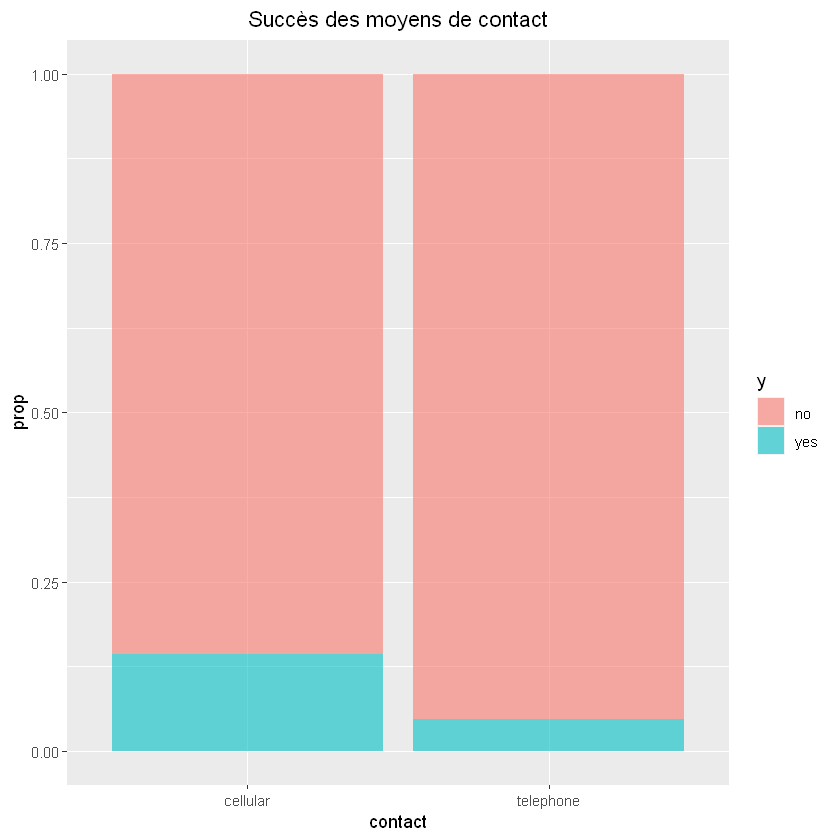

In [10]:
data %>% 
ggplot() + aes(contact, fill = y) + geom_bar(position="fill", alpha = 0.6) +
labs(title = "Succès des moyens de contact", y = "prop") +
theme(plot.title = element_text(hjust = 0.5))

## 2. Variables quantitatives

L'analyse de la corrélation entre les variables quantitatives démontre une corrélation entre la récence de l'appel et la fréquence.  
Autrement, les corrélations sont faibles.

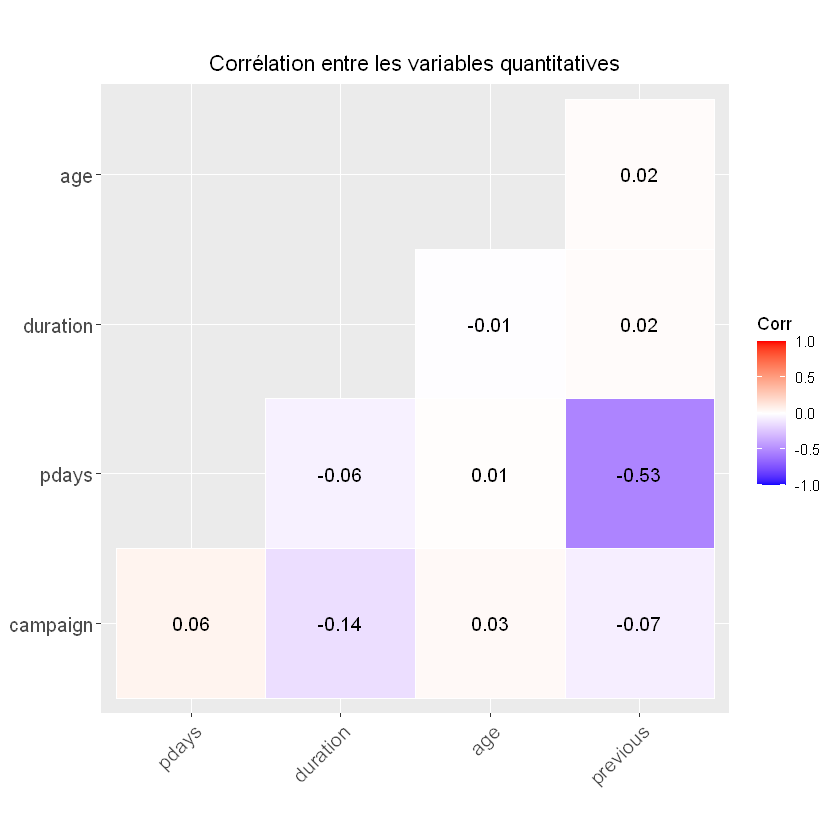

In [11]:
data %>% 
select(age, duration, campaign, pdays, previous) %>% cor() %>% 
ggcorrplot(hc.order = T, type = "lower", lab = T,
           outline.col = "white", ggtheme = theme_gray) + 
labs(title = "Corrélation entre les variables quantitatives") +
theme(plot.title = element_text(hjust = 0.5))

In [12]:
p_age <- data %>% 
ggplot() + aes(x = age, fill = y) + geom_density(alpha = 0.5) +
labs(title = "Age", y = NULL) +
theme(plot.title = element_text(hjust = 0.5))

p_duree <- data %>% 
ggplot() + aes(x = duration, fill = y) + geom_density(alpha = 0.5) +
labs(title = "Durée", y = NULL) + xlim(c(0, 1750)) +
theme(plot.title = element_text(hjust = 0.5))

p_pdays <- data %>% 
ggplot() + aes(x = pdays, fill = y) + geom_density(alpha = 0.5) +
labs(title = "Récence", y = NULL) +
theme(plot.title = element_text(hjust = 0.5))

p_campaign <- data %>% 
ggplot() + aes(x = campaign, fill = y) + geom_density(alpha = 0.5) +
labs(title = "Fréquence", y = NULL) + xlim(c(0, 10)) +
theme(plot.title = element_text(hjust = 0.5))

quantlist <- list(p_age, p_duree, p_pdays, p_campaign)

Il est intéressant de visualiser la distribution de chaque variables quantitatives en fonction des modalités de $Y$.  
On peut voir que les variables `age` et de la récence (`campaign`) sont pratiquements confondues pour chaque modalité de $Y$. La variable de la durée en revanche possède une bonne variance, cette variable sera importante dans notre étude.

Warning message:
"Removed 2 rows containing non-finite values (stat_density)."Warning message:
"Removed 26 rows containing non-finite values (stat_density)."

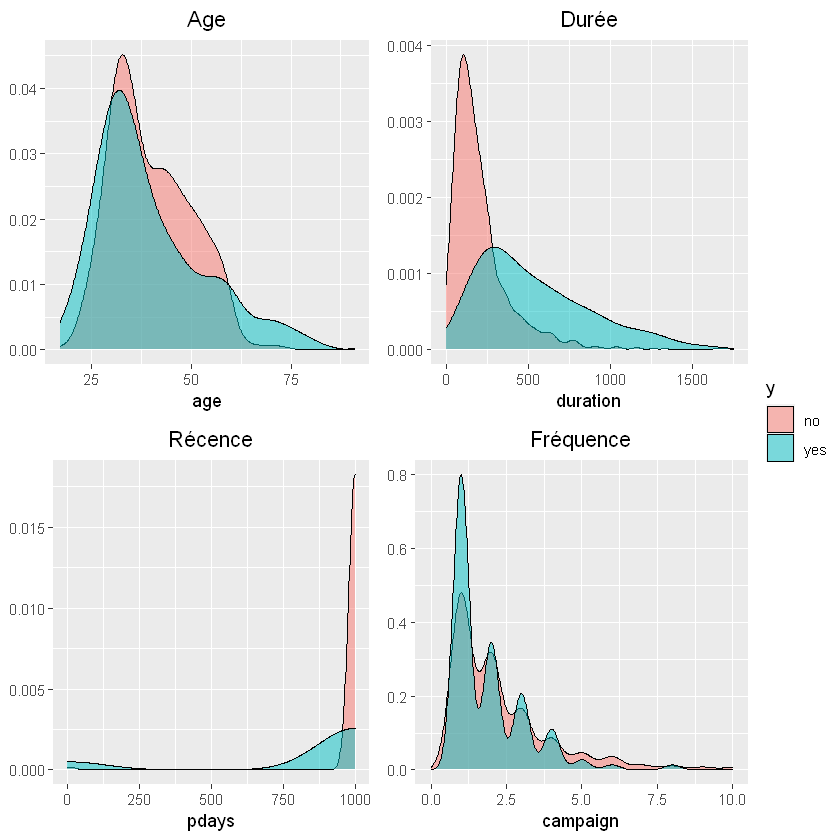

In [13]:
ggarrange(
    plotlist = quantlist,
    ncol = 2, nrow = 2,
    common.legend = T,
    legend = "right"
)

# II. Features Engineering
Afin de réduire la dimension de $X$, il est nécessaire de nettoyer et d'éliminer les variables qui peuvent être superflues pour nos modèles.  
Nous procèderons en 2 temps, en éliminant les variables non significatives sur un modèle naïf pré-entraîné et en regroupant des modalités de variables qualitatives qui ont peu voire pas de variances entre elles.

## 1. Significativité des variables
Entraînons un modèle naïf sur les données d'entraînement (naïves aussi, du coup).  
Ensuite, nous effectuons une analyse de la significativité des variables par tests multiples:

In [14]:
train_naive <- split_set(data)[[1]]

model_naive <- glm(y~., data = train_naive, family = binomial)
Anova(model_naive, type = 3, test.statistic = "Wald") %>% print()

Analysis of Deviance Table (Type III tests)

Response: y
            Df   Chisq Pr(>Chisq)    
(Intercept)  1  1.8882   0.169410    
age          1  0.1524   0.696249    
job         11 16.0171   0.140497    
marital      3  3.9336   0.268720    
education    6  4.6992   0.582924    
default      1  3.9837   0.045941 *  
housing      2  0.1082   0.947326    
contact      1 10.4101   0.001253 ** 
day_of_week  4  4.7171   0.317576    
duration     1 69.1072  < 2.2e-16 ***
campaign     1  1.4158   0.234101    
pdays        1  0.6221   0.430269    
previous     1  1.5996   0.205961    
poutcome     2  3.4678   0.176590    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


L'analyse de la significativité confirme nos déscripions plus haut.  
En effet, l'âge, l'éducation, les jours de la semaine et la récence possèdent une grande p-value pour le test du $\chi^2$. Nous éliminons aussi la variable housing.

In [15]:
clean_data <- data %>% 
select(-c(age, education, housing, day_of_week, pdays))

## 2. Correction des modalités
Désormais, il est nécessaire de regrouper des modalités:

- Marital: la modalité `unknown` n'est présente que 2 fois sur les 1000 individus. L'analyse descriptive démontre que ces personnes possèdent un profil proche des célibataires. Elles seront converties ainsi donc.
- Job: plusieurs profil de job ont une variance faible au vu de l'éducation, du statut marital et de $Y$, elles seront groupées.

In [16]:
clean_data <- clean_data %>% 
mutate(
    marital = factor(if_else(
        marital == "unknown",
        "single", as.character(marital)
    )),
    job = factor(case_when(
        job == "admin." ~ "management",
        job == "self-employed" ~ "entrepreneur",
        job == "housemaid" ~ "services",
        TRUE ~ as.character(job)
    )),
    y = if_else(
        y == "no",
        0, 1
    )
)

Enfin, séparons nos échantillons à partir des données nettoyées.

In [17]:
train_set <- split_set(clean_data)[[1]]
test_set <- split_set(clean_data)[[2]]

# III. Construction des scores
Nous rappelons que l'échantillons a été découpé en 80% - 20%. La matrice de confusion "parfaite" est donc la suivante. Elle est utile pour les interprétations qui suivent.

In [18]:
table(prev = test_set$y,
      obs = test_set$y)

    obs
prev   0   1
   0 180   0
   1   0  20

## 1. Modèle sur les nouvelles variables
Nous allons ajusté notre premier modèle sur les variables qu'on a sélectionné précédemment.

In [19]:
model_1 <- glm(y~., data = train_set, family = binomial)

summary(model_1)


Call:
glm(formula = y ~ ., family = binomial, data = train_set)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4435  -0.3963  -0.2479  -0.1365   2.8225  

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -6.338e+00  1.474e+00  -4.301 1.70e-05 ***
jobentrepreneur      1.061e-01  6.915e-01   0.153 0.878100    
jobmanagement        2.169e-01  3.983e-01   0.544 0.586107    
jobretired           1.250e+00  5.866e-01   2.131 0.033117 *  
jobservices         -6.344e-01  5.568e-01  -1.139 0.254550    
jobstudent           2.962e-01  7.846e-01   0.378 0.705748    
jobtechnician        3.015e-02  4.644e-01   0.065 0.948236    
jobunemployed        3.715e-01  1.033e+00   0.359 0.719270    
jobunknown          -1.145e+01  6.901e+02  -0.017 0.986759    
maritalmarried      -3.242e-01  4.773e-01  -0.679 0.497008    
maritalsingle        1.820e-01  5.129e-01   0.355 0.722706    
defaultunknown      -4.308e-01  3.909e-01  -1.102 

On a plus de variables significatives par rapport au modèle naïf, toutefois, elles sont peu nombreuses.  
Effectuons des tests multiples pour chaque colonne.

In [20]:
Anova(model_1, type = 3, test.statistic = "Wald") %>% print()

Analysis of Deviance Table (Type III tests)

Response: y
            Df   Chisq Pr(>Chisq)    
(Intercept)  1 18.4962  1.702e-05 ***
job          8  8.1014  0.4236263    
marital      2  2.6334  0.2680134    
default      1  1.2148  0.2703841    
contact      1 14.1022  0.0001731 ***
duration     1 77.9649  < 2.2e-16 ***
campaign     1  4.2090  0.0402108 *  
previous     1  6.5243  0.0106412 *  
poutcome     2 17.9450  0.0001268 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Les variables marital, default et job ne semblent pas avoir d'effet sur $Y$.

Effectuons nos préductions sur l'échantillon test et visualisons le résulat.

In [22]:
model_1_pred <- predict(model_1, newdata = test_set, type = 'response')  %>% round()

Kendall(model_1_pred, test_set$y)

tau = 0.306, 2-sided pvalue =1.6332e-05

La p-value de tau de Kendall est faible, il y a indépendance entre les variables.

La matrice de confusion démontre que ce modèle ne classe bien que le quart des personnes qui veulent souscrire.

In [23]:
table(prev = model_1_pred,
      obs = test_set$y)

    obs
prev   0   1
   0 175  15
   1   5   5

In [24]:
roclist <- vector(mode = "list")
roclist[["Model_1"]] <- roc(model_1_pred, test_set$y)

Setting levels: control = 0, case = 1
Setting direction: controls < cases


Nous enregistrons chaque valeur des métriques dans la table `result` au vu de la comparaison.

In [25]:
result <- tibble(
    Model = "Model_1",
    AIC = model_1$aic,
    BIC = BIC(model_1),
    Accuracy = 1 - mean(model_1_pred!=test_set$y),
    AUC = roc(model_1_pred, test_set$y)$auc,
    Kendall = Kendall(model_1_pred, test_set$y)$tau
    )

result

Setting levels: control = 0, case = 1
Setting direction: controls < cases


Model,AIC,BIC,Accuracy,AUC,Kendall
Model_1,405.2644,489.5874,0.9,0.7105263,0.3058876


Nous avons un Accuracy élevé, 90%, ce qui est une bonne chose.

Nous allons sélectionner nos variables par étapes en enlevant une par une, tout en optimisant sur la métrique de l'AIC.

## 2. Sélection par étape
Effectuons une procédure pas à pas descendante.

In [26]:
model_2 <- step(model_1, direction = "backward", trace = F)

summary(model_2)


Call:
glm(formula = y ~ default + contact + duration + campaign + previous + 
    poutcome, family = binomial, data = train_set)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.6931  -0.4142  -0.2471  -0.1530   2.7171  

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -6.7073431  1.4108377  -4.754 1.99e-06 ***
defaultunknown      -0.5270555  0.3823484  -1.378 0.168059    
contacttelephone    -1.4202401  0.3814699  -3.723 0.000197 ***
duration             0.0037925  0.0004325   8.769  < 2e-16 ***
campaign            -0.2438311  0.1147627  -2.125 0.033615 *  
previous             2.4141954  0.8388873   2.878 0.004004 ** 
poutcomenonexistent  4.1705690  1.3702143   3.044 0.002337 ** 
poutcomesuccess      3.8315719  0.8398522   4.562 5.06e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 562.74  on 799  degrees of fr

Le meilleur modèle ne garde que 7 variables explicatives, ce qui est déjà loin de nos 35 variables. Elle a en effet supprimé les variables `marital` mais aussi `job` qui possède 9 modalités après nos transformations.

L'analyse du $\chi^2$ démontre qu'il ne reste plus que la variable `default` qui n'a pas d'effet sur $Y$.

In [27]:
Anova(model_2, type = 3, test.statistic = "Wald") %>% print()

Analysis of Deviance Table (Type III tests)

Response: y
            Df   Chisq Pr(>Chisq)    
(Intercept)  1 22.6020  1.993e-06 ***
default      1  1.9002  0.1680585    
contact      1 13.8613  0.0001968 ***
duration     1 76.8918  < 2.2e-16 ***
campaign     1  4.5142  0.0336154 *  
previous     1  8.2820  0.0040039 ** 
poutcome     2 21.5338  2.109e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Effectuons nos prédictions et visualisons les résultats.

In [28]:
model_2_pred <- predict(model_2, newdata = test_set, type = 'response')  %>% round()

Kendall(model_2_pred, test_set$y)

tau = 0.272, 2-sided pvalue =0.00012636

In [29]:
table(prev = model_2_pred,
      obs = test_set$y)

    obs
prev   0   1
   0 176  16
   1   4   4

In [30]:
roclist[["Model_2"]] <- roc(model_2_pred, test_set$y)

result <- result %>%
bind_rows(
    tibble(
        Model = "Model_2",
        AIC = model_2$aic,
        BIC = BIC(model_2),
        Accuracy = 1 - mean(model_2_pred!=test_set$y),
        AUC = roc(model_2_pred, test_set$y)$auc,
        Kendall = Kendall(model_2_pred, test_set$y)$tau
    )
)

Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
"Vectorizing 'auc' elements may not preserve their attributes"Warning message in bind_rows_(x, .id):
"Vectorizing 'auc' elements may not preserve their attributes"

In [31]:
result[2,]

Model,AIC,BIC,Accuracy,AUC,Kendall
Model_2,396.3934,433.8703,0.9,0.7083333,0.2721655


L'accuracy, qui est déjà très bien, n'a pas bougé. Par contre, on a de meilleurs AIC et BIC, mais au prix de la baisse de l'AUC.

Essayons à présente de trouver le meilleur modèle ajusté sur l'AIC, maintenant qu'on est pleinement dans la validité de la régression logistique.
## 3. BestGLM avec l'AIC

Pour se faire, nous devons définir manuellement notre matrice design $X$. Ensuite nous séparons en 2 échantillons.

In [32]:
marital <- data.frame(dummy(clean_data$marital)[,-1])
poutcome <- data.frame(dummy(clean_data$poutcome)[,-1])

dummy_data <- bind_cols(
    marital, poutcome,
    clean_data[,3:7],
    y = clean_data$y
)

train_dummy <- split_set(dummy_data)[[1]]
test_dummy <- split_set(dummy_data)[[2]]

Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
"non-list contrasts argument ignored"Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
"non-list contrasts argument ignored"

Recherons le meilleur modèle.

In [33]:
model_3 <- bestglm(train_dummy, family = binomial, IC = 'AIC')$BestModel
summary(model_3)

Morgan-Tatar search since family is non-gaussian.



Call:
glm(formula = y ~ ., family = family, data = Xi, weights = weights)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8064  -0.4075  -0.2489  -0.1511   2.7888  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -6.568165   1.408221  -4.664 3.10e-06 ***
NAmarried        -0.495715   0.274606  -1.805 0.071045 .  
NAnonexistent     4.165570   1.367746   3.046 0.002322 ** 
NAsuccess         3.862588   0.843484   4.579 4.66e-06 ***
contacttelephone -1.429269   0.379180  -3.769 0.000164 ***
duration          0.003860   0.000438   8.813  < 2e-16 ***
campaign         -0.239056   0.113154  -2.113 0.034630 *  
previous          2.470005   0.843183   2.929 0.003396 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 562.74  on 799  degrees of freedom
Residual deviance: 379.18  on 792  degrees of freedom
AIC: 395.18

Number of Fisher S

Par rapport au modèle 2, le modèle 3 ne garde que 2 modalités de la variable `marital` et toutes les variables sont significatives au moins au seuil de 10%.

Effectuons nos prédictions et visualisons.

In [34]:
model_3_pred <- predict(model_3, newdata = test_dummy, type = 'response')  %>% round()

Kendall(model_3_pred, test_dummy$y)

tau = 0.306, 2-sided pvalue =1.6332e-05

In [35]:
table(prev = model_3_pred,
      obs = test_dummy$y)

    obs
prev   0   1
   0 175  15
   1   5   5

In [40]:
roclist[["Model_3"]] <- roc(model_3_pred, test_dummy$y)

result <- result %>%
bind_rows(
    tibble(
        Model = "Model_3",
        AIC = model_3$aic,
        BIC = BIC(model_3),
        Accuracy = 1 - mean(model_3_pred!=test_dummy$y),
        AUC = roc(model_3_pred, test_dummy$y)$auc,
        Kendall = Kendall(model_3_pred, test_dummy$y)$tau
    )
)

Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
"Vectorizing 'auc' elements may not preserve their attributes"

Nos AIC et BIC ont encore baissé et on retrouve un AUC à la hausse.

In [41]:
result[3,]

Model,AIC,BIC,Accuracy,AUC,Kendall
Model_3,395.1842,432.6611,0.9,0.7105263,0.3058876


Enfin, ajustons par rapport au BIC
## 4. BestGLM avec le BIC

In [37]:
model_4 <- bestglm(train_dummy, family = binomial, IC = 'BIC')$BestModel
summary(model_4)

Morgan-Tatar search since family is non-gaussian.



Call:
glm(formula = y ~ ., family = family, data = Xi, weights = weights)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8427  -0.3975  -0.3154  -0.1814   2.8398  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -3.2378912  0.2278379 -14.211  < 2e-16 ***
NAsuccess         3.2868422  0.5726771   5.739  9.5e-09 ***
contacttelephone -1.3111643  0.3672898  -3.570 0.000357 ***
duration          0.0037928  0.0004268   8.887  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 562.74  on 799  degrees of freedom
Residual deviance: 401.05  on 796  degrees of freedom
AIC: 409.05

Number of Fisher Scoring iterations: 6


Le modèle ne garde que 3 variables dont `poutcome` à deux modalités.

In [38]:
model_4_pred <- predict(model_4, newdata = test_dummy, type = 'response')  %>% round()

Kendall(model_4_pred, test_dummy$y)

tau = 0.299, 2-sided pvalue =2.4915e-05

In [39]:
table(prev = model_4_pred,
      obs = test_dummy$y)

    obs
prev   0   1
   0 177  16
   1   3   4

In [43]:
roclist[["Model_4"]] <- roc(model_4_pred, test_dummy$y)

result <- result %>%
bind_rows(
    tibble(
        Model = "Model_4",
        AIC = model_4$aic,
        BIC = BIC(model_4),
        Accuracy = 1 - mean(model_4_pred!=test_dummy$y),
        AUC = roc(model_4_pred, test_dummy$y)$auc,
        Kendall = Kendall(model_4_pred, test_dummy$y)$tau
    )
)

Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
"Vectorizing 'auc' elements may not preserve their attributes"

Notre AUC est en forte hausse par rapport aux 3 autres modèles, par contre l'AIC et le BIC est moins optimal par rapport au modèle 3.

In [44]:
result[4,]

Model,AIC,BIC,Accuracy,AUC,Kendall
Model_4,409.0481,427.7866,0.905,0.7442635,0.2992713


# IV. Comparaison et sélection de modèle

In [102]:
scale1 <- result %>% 
select(-c(AIC, BIC)) %>% 
gather(metric, value, -Model) %>% 
ggplot() +
aes(fill = metric, y = value, x = Model) +
geom_bar(position = "dodge", stat = "identity", alpha = 0.6) +
coord_flip(ylim = c(0.25, 0.9)) +
labs(title = "Accuracy, AUC et Kendall") +
theme(plot.title = element_text(hjust = 0.5),
     legend.position="bottom")

scale2 <- result %>% 
select(AIC, BIC, Model) %>% 
gather(metric, value, -Model) %>% 
ggplot() + coord_cartesian(ylim = c(350, 500)) +
aes(fill = metric, y = value, x = Model) +
geom_bar(position = "dodge", stat = "identity", alpha = 0.6) +
labs(title = "AIC et BIC par modèle", y = NULL) +
theme(plot.title = element_text(hjust = 0.5),
     legend.position="bottom")

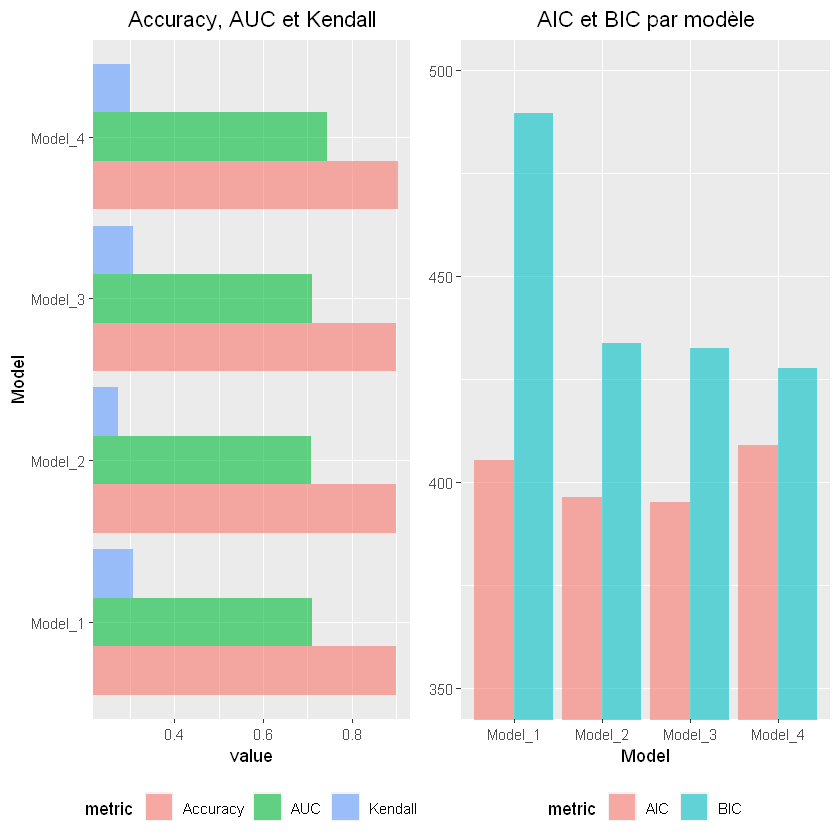

In [103]:
ggarrange(
    scale1, scale2,
    ncol = 2, nrow = 1
)

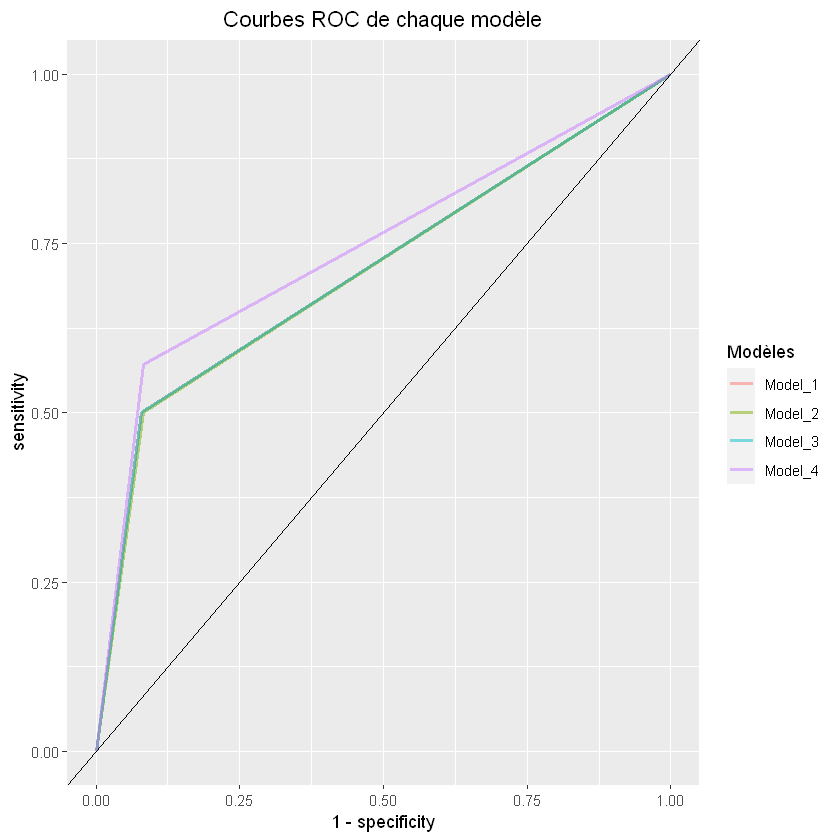

In [58]:
ggroc(roclist, aes = "color", size = 0.9, legacy.axes = TRUE, alpha = 0.5) +
labs(color = "Modèles", title = "Courbes ROC de chaque modèle") + geom_abline() +
theme(plot.title = element_text(hjust = 0.5))

Au vu de nos résultats, on gardera le modèle 4.